In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import entropy

def load_arff_manually(file_path):
    """Manual ARFF file loader that handles the specific format of ldsmall.arff"""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    data_start = None
    attributes = []
    for i, line in enumerate(lines):
        if line.lower().startswith('@attribute'):
            attr_name = line.split()[1]
            attributes.append(attr_name)
        elif line.lower().startswith('@data'):
            data_start = i + 1
            break
    
    if data_start is None:
        raise ValueError("Could not find @DATA section in ARFF file")
    
    # Parse data rows
    data = []
    for line in lines[data_start:]:
        line = line.strip()
        if line and not line.startswith('%'):

            if line.endswith(','):
                line = line[:-1]
            values = line.split(',')
            data.append([float(v) if '.' in v else int(v) for v in values])
    
    return pd.DataFrame(data, columns=attributes)

try:
    df = load_arff_manually('ldsmall.arff')
    feature_cols = [col for col in df.columns if col != 'class']
    print(f"Successfully loaded data with {len(df)} samples and {len(feature_cols)} features")
    print("First 5 rows:")
    print(df.head())
except Exception as e:
    print(f"Error loading ARFF file: {e}")
    raise

Successfully loaded data with 200000 samples and 24 features
First 5 rows:
   att1  att2  att3  att4  att5  att6  att7  att8  att9  att10  ...  att16  \
0     1     1     0     1     1     1     0     1     1      0  ...      1   
1     0     0     1     0     1     1     0     1     1      1  ...      0   
2     0     0     1     1     1     0     1     1     0      1  ...      0   
3     1     1     0     0     0     1     0     1     0      0  ...      0   
4     1     0     1     1     0     0     0     0     1      1  ...      1   

   att17  att18  att19  att20  att21  att22  att23  att24  class  
0      1      1      0      0      1      0      0      0      5  
1      1      0      0      1      1      0      1      1      9  
2      0      0      0      1      0      1      0      0      2  
3      0      1      1      1      1      1      0      0      7  
4      0      0      0      0      0      0      1      1      4  

[5 rows x 25 columns]


In [4]:

def get_distribution_stats(data_window):
    return {
        'mean': np.mean(data_window, axis=0),
        'std': np.std(data_window, axis=0),
        'entropy': [entropy([np.mean(data_window[:, i]), 1-np.mean(data_window[:, i])], base=2) 
                   if 0 < np.mean(data_window[:, i]) < 1 else 0
                   for i in range(data_window.shape[1])]
    }

window_size = min(200, len(df)//4) 
step_size = max(50, window_size//2) 
threshold = 1.50 

windows = []
drift_scores = []
label_distributions = []

for i in range(0, len(df)-window_size+1, step_size):
    current_window = df[feature_cols].iloc[i:i+window_size].values
    current_labels = df['class'].iloc[i:i+window_size]

    stats = get_distribution_stats(current_window)
    windows.append(stats)

    label_dist = current_labels.value_counts(normalize=True).sort_index()
    label_distributions.append(label_dist)

    if i == 0:
        base_stats = stats
        base_label_dist = label_dist
        drift_score = 0
    else:
        mean_diff = np.sum(np.abs(stats['mean'] - base_stats['mean']))
        entropy_diff = np.sum(np.abs(np.array(stats['entropy']) - np.array(base_stats['entropy'])))

        label_diff = np.sum(np.abs(label_dist - base_label_dist))
        
        drift_score = mean_diff + entropy_diff * 0.5 + label_diff * 0.5
        
    drift_scores.append(drift_score)

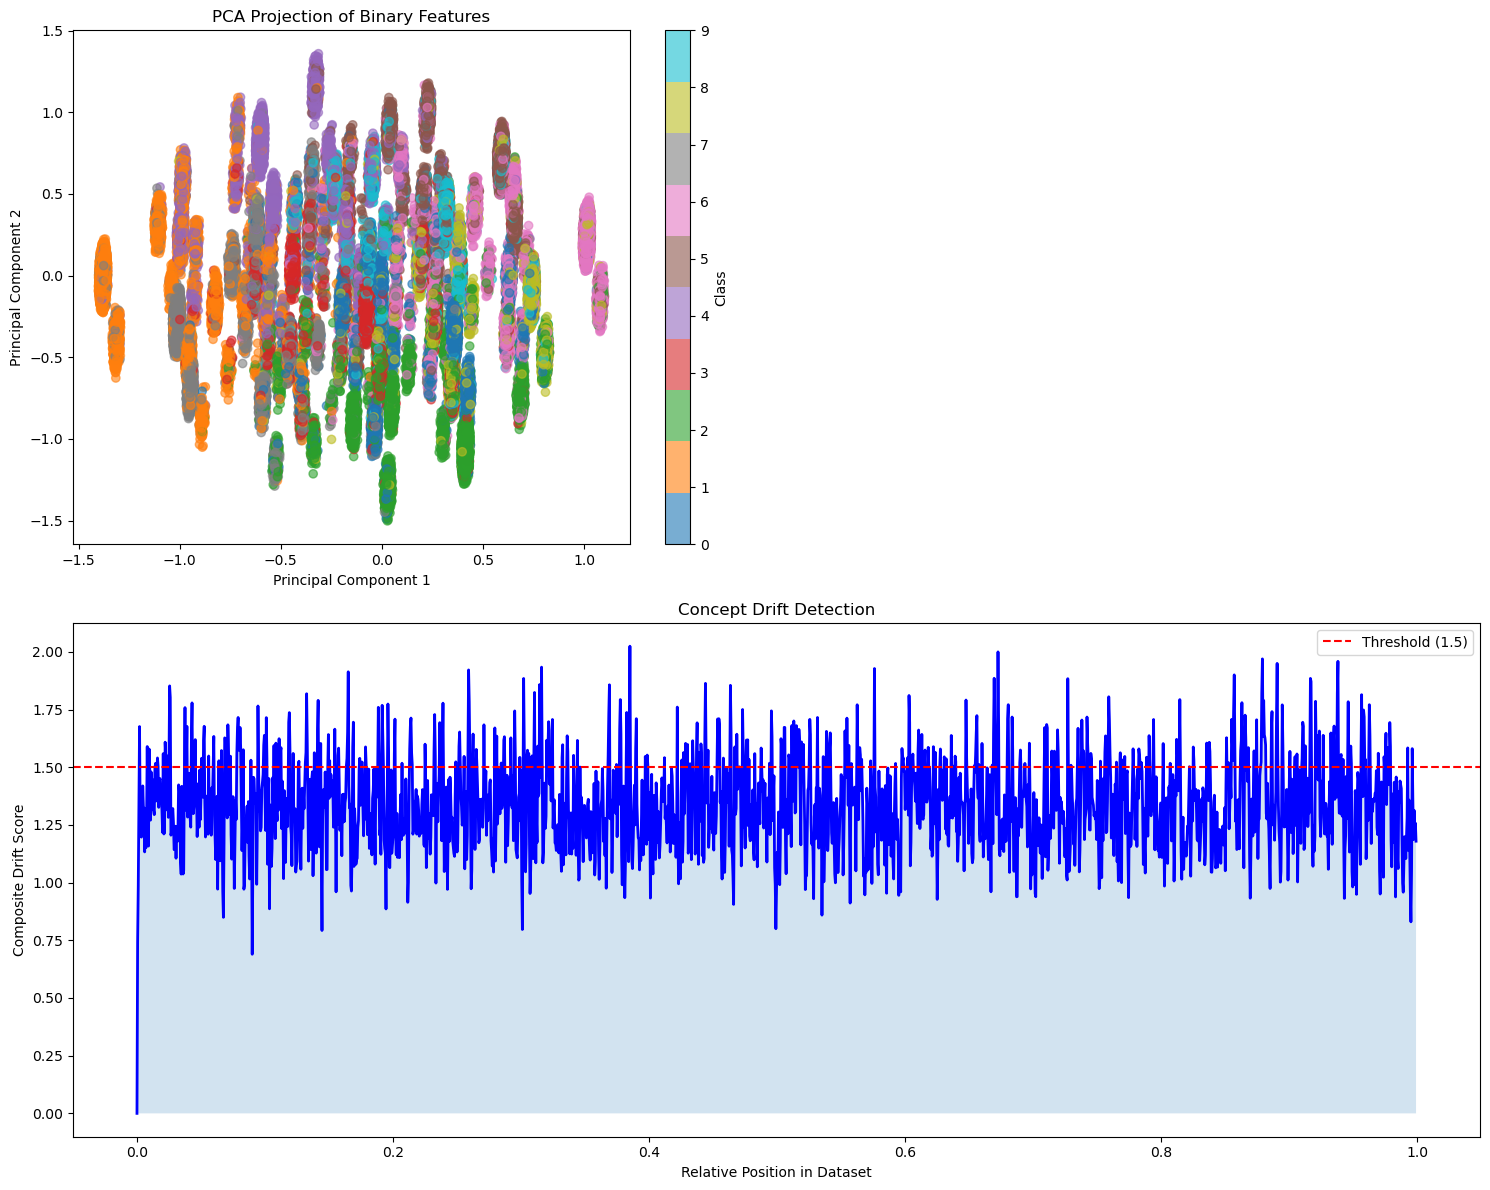

In [5]:

plt.figure(figsize=(15, 12))

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feature_cols])
plt.subplot(221)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                     c=df['class'], cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Class')
plt.title('PCA Projection of Binary Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')


plt.subplot(212)
window_positions = np.arange(len(drift_scores)) * step_size / len(df)
plt.plot(window_positions, drift_scores, 'b-', linewidth=2)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
plt.fill_between(window_positions, drift_scores, alpha=0.2)
plt.title('Concept Drift Detection')
plt.xlabel('Relative Position in Dataset')
plt.ylabel('Composite Drift Score')
plt.legend()

plt.tight_layout()
plt.show()